In [1]:
import pandas as pd
import numpy as np
import os
import json
from joblib import dump, load
from xml.dom import minidom

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as skmet
from sklearn import preprocessing

In [2]:
# DATA PATHS
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/WH18/test/"
czi_path = f"{ROOT_DIR}3x3-extract-Scene6-07-14to15_stitched.czi"
trackmate_path = f"{ROOT_DIR}filtered_spots.csv"
annotations_path = f"{ROOT_DIR}control_1.xml"
tiff_path = f"{ROOT_DIR}composite.tif"

In [3]:
df = pd.read_csv(trackmate_path)
print(f"{df.shape=}")
df.tail()

df.shape=(19113, 49)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,FILE,STEP,MAX_STEP
19108,ID20122,20122,control_1_99,0.752005,1478.090196,798.642493,0.0,47095.593995,47,8.731575,...,5.643181,0.751487,2.423244,239.516306,68.236381,0.646417,0.944649,control_1,47,51
19109,ID20505,20505,control_1_99,0.758493,1479.416804,798.790484,0.0,48097.627910,48,9.033331,...,6.114858,0.959091,2.211688,256.357297,68.723760,0.682090,0.944828,control_1,48,51
19110,ID20930,20930,control_1_99,0.717909,1477.669536,796.939717,0.0,49099.661825,49,8.506987,...,5.502950,1.006227,2.417370,227.353369,67.569098,0.625770,0.934615,control_1,49,51
19111,ID21275,21275,control_1_99,0.762485,1473.402200,792.166219,0.0,50101.695739,50,8.731575,...,5.766373,0.808552,2.316275,239.516306,67.722170,0.656271,0.934307,control_1,50,51
19112,ID21673,21673,control_1_99,0.751147,1471.841692,789.521206,0.0,51103.729654,51,7.640128,...,5.422590,0.740838,2.033492,183.379672,58.939011,0.663369,0.942308,control_1,51,51


In [4]:


def load_cvat_xml(fpath):
    
    new_rows = []
    f = open(fpath,'r')
    xmldoc = minidom.parse(f)
    items = xmldoc.getElementsByTagName('image')
    
    for item in items:
        
        try:
            l = item.getElementsByTagName('tag')
            assert(len(l) > 0)
        except:
            continue
        
        FILENAME = item.attributes['name'].value
        TRACK_ID = FILENAME.split("_frame_")[0]
        FRAME = int(FILENAME.split("frame_")[1].replace(".png", ""))
        LABEL = item.getElementsByTagName('tag')[0].attributes['label'].value

        row = {
            "id" : item.attributes['id'].value,
            "filename" :FILENAME,
            "FRAME" : FRAME,
            "TRACK_ID" : TRACK_ID,
            "category_id" : LABEL
        }
        new_rows.append(row)
        
    return pd.DataFrame(new_rows)
 
    
annotations = load_cvat_xml(annotations_path)
annotations.head()

,id,filename,FRAME,TRACK_ID,category_id
0,11213,control_1_9_frame_0051.png,51,control_1_9,G1
1,11212,control_1_9_frame_0050.png,50,control_1_9,G1
2,11211,control_1_9_frame_0049.png,49,control_1_9,G1
3,11210,control_1_9_frame_0048.png,48,control_1_9,G1
4,11209,control_1_9_frame_0047.png,47,control_1_9,G1


In [5]:
# ann = json.load(open(annotations_path))
# print(f"{ann.keys()=}")

# ann_df = pd.DataFrame(ann['annotations'])

# ann_df.head()

# file_ids = pd.DataFrame(ann['images'])

# file_ids.head()

# ann_df = ann_df[['image_id', 'category_id']]
# ann_df = ann_df.rename({'image_id': 'id'}, axis=1)
# file_ids = file_ids[['id', 'file_name']]

# get_track = lambda x: int(x.split("_")[0].replace("track", ""))
# get_frame = lambda x: int(x.split("_")[1].replace("frame", "").replace(".png", ""))

# ann_df = pd.merge(ann_df, file_ids, on='id', how='left')
# ann_df['TRACK_ID'] = ann_df['file_name'].apply(get_track)
# ann_df['FRAME'] = ann_df['file_name'].apply(get_frame)

# label2label = {
#     1 : "G1",
#     2 : "S",
#     3 : "G2/M",
#     4 : 'NA',
# }


# ann_df = ann_df.replace({"category_id": label2label})


# print(f"{ann_df.shape=}")
# ann_df.head()

In [5]:
print(f"{dict(df[['TRACK_ID', 'FRAME']].dtypes)=}")
print(f"{dict(annotations[['TRACK_ID', 'FRAME']].dtypes)=}")

df['TRACK_ID']

df = pd.merge(
    df, annotations, 
    on=['TRACK_ID', 'FRAME'],
    how='left'
)

print(f"{df.shape=}")


df2 = df[df['category_id'].notna()]
print(f"{df2.shape=}")

dict(df[['TRACK_ID', 'FRAME']].dtypes)={'TRACK_ID': dtype('O'), 'FRAME': dtype('int64')}
dict(annotations[['TRACK_ID', 'FRAME']].dtypes)={'TRACK_ID': dtype('O'), 'FRAME': dtype('int64')}
df.shape=(19113, 52)
df2.shape=(11212, 52)


In [6]:
df2['category_id'].value_counts(dropna=False)

G1    7113
S     1969
G2    1473
NA     657
Name: category_id, dtype: int64

In [7]:
def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    
    df = df.rename(columns=rename_dict)
    return df

# rename some columns
df2 = col_renamer(df2, 'CH1', 'RED')
df2 = col_renamer(df2, 'CH2', 'GREEN')
df2 = col_renamer(df2, 'CH3', 'BLUE')

In [8]:
df2.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'FILE', 'STEP', 'MAX_STEP', 'id', 'filename', 'category_id'],
      dtype='object')

In [9]:



X = [
    'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED','MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED', 'STD_INTENSITY_RED', 'CONTRAST_RED', 'SNR_RED', 
    'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN','MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN', 'STD_INTENSITY_GREEN', 'CONTRAST_GREEN', 'SNR_GREEN', 
    'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE', 'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE','STD_INTENSITY_BLUE', 'CONTRAST_BLUE', 'SNR_BLUE', 
    'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
]


one_hot = pd.get_dummies(df2['category_id'])

df2 = df2.join(one_hot)

y = ['G1', 'S', 'G2', 'NA']

print(f"{df2[X].shape=}")
print(f"{df2[y].shape=}")

pd.options.mode.use_inf_as_na = True
df2[X].isna().sum()

df2[X].dtypes


df2[X].shape=(11212, 35)
df2[y].shape=(11212, 4)


MEAN_INTENSITY_RED        float64
MEDIAN_INTENSITY_RED      float64
MIN_INTENSITY_RED         float64
MAX_INTENSITY_RED         float64
TOTAL_INTENSITY_RED       float64
STD_INTENSITY_RED         float64
CONTRAST_RED              float64
SNR_RED                   float64
MEAN_INTENSITY_GREEN      float64
MEDIAN_INTENSITY_GREEN    float64
MIN_INTENSITY_GREEN       float64
MAX_INTENSITY_GREEN       float64
TOTAL_INTENSITY_GREEN     float64
STD_INTENSITY_GREEN       float64
CONTRAST_GREEN            float64
SNR_GREEN                 float64
MEAN_INTENSITY_BLUE       float64
MEDIAN_INTENSITY_BLUE     float64
MIN_INTENSITY_BLUE        float64
MAX_INTENSITY_BLUE        float64
TOTAL_INTENSITY_BLUE      float64
STD_INTENSITY_BLUE        float64
CONTRAST_BLUE             float64
SNR_BLUE                  float64
RADIUS                    float64
ELLIPSE_X0                float64
ELLIPSE_Y0                float64
ELLIPSE_MAJOR             float64
ELLIPSE_MINOR             float64
ELLIPSE_THETA 

In [10]:
# handle in values
for c in X:
    if df2[c].isna().sum() > 0:
        df2[c] = np.where(df2[c].isna(), df2[c].max(), df2[c])
        
df2[X].isna().sum()

MEAN_INTENSITY_RED        0
MEDIAN_INTENSITY_RED      0
MIN_INTENSITY_RED         0
MAX_INTENSITY_RED         0
TOTAL_INTENSITY_RED       0
STD_INTENSITY_RED         0
CONTRAST_RED              0
SNR_RED                   0
MEAN_INTENSITY_GREEN      0
MEDIAN_INTENSITY_GREEN    0
MIN_INTENSITY_GREEN       0
MAX_INTENSITY_GREEN       0
TOTAL_INTENSITY_GREEN     0
STD_INTENSITY_GREEN       0
CONTRAST_GREEN            0
SNR_GREEN                 0
MEAN_INTENSITY_BLUE       0
MEDIAN_INTENSITY_BLUE     0
MIN_INTENSITY_BLUE        0
MAX_INTENSITY_BLUE        0
TOTAL_INTENSITY_BLUE      0
STD_INTENSITY_BLUE        0
CONTRAST_BLUE             0
SNR_BLUE                  0
RADIUS                    0
ELLIPSE_X0                0
ELLIPSE_Y0                0
ELLIPSE_MAJOR             0
ELLIPSE_MINOR             0
ELLIPSE_THETA             0
ELLIPSE_ASPECTRATIO       0
AREA                      0
PERIMETER                 0
CIRCULARITY               0
SOLIDITY                  0
dtype: int64

In [11]:
df2[y].value_counts()

G1  S  G2  NA
1   0  0   0     7113
0   1  0   0     1969
    0  1   0     1473
       0   1      657
dtype: int64

In [12]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df2[X], df2[y], test_size=0.05)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

print(f"\n{X_train.shape=}")
print(f"{y_train.shape=}")

print(f"\n{X_test.shape=}")
print(f"{y_test.shape=}")

print(f"\n{X_holdout.shape=}")
print(f"{y_holdout.shape=}")


X_train.shape=(7455, 35)
y_train.shape=(7455, 4)

X_test.shape=(3196, 35)
y_test.shape=(3196, 4)

X_holdout.shape=(561, 35)
y_holdout.shape=(561, 4)


In [13]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X

# use the trainning data to transform the testing data
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

X_holdout = scaler.transform(X_holdout)
X_holdout = pd.DataFrame(X_holdout)
print("done.")

done.


In [14]:
model = RandomForestClassifier(bootstrap=True,
                               n_estimators=100)

model.fit(X_train, y_train)

dump(model, 'rf_model.joblib')
dump(scaler, 'rf_scaler.joblib')

y_pred = model.predict(X_test)
auc = skmet.roc_auc_score(y_test, y_pred, multi_class='ovo')
print(f"{auc=:.5f}")
print()

target_names = ['G1', 'S', 'G2/M', 'NA']
cm = skmet.confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
cm = pd.DataFrame(cm)
cm.index = target_names
cm.columns = target_names
print(cm)

print()
report = skmet.classification_report(y_test, y_pred, target_names=target_names)
print(report)

auc=0.94538

        G1    S  G2/M   NA
G1    1981    2    12   13
S        5  566    16    4
G2/M    27   21   372    3
NA      29    4     0  141

              precision    recall  f1-score   support

          G1       0.98      0.98      0.98      2008
           S       0.95      0.96      0.96       591
        G2/M       0.93      0.88      0.90       423
          NA       0.88      0.81      0.84       174

   micro avg       0.96      0.96      0.96      3196
   macro avg       0.93      0.91      0.92      3196
weighted avg       0.96      0.96      0.96      3196
 samples avg       0.96      0.96      0.96      3196



/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances['cumsum'] = feature_importances['importance'].cumsum()
feature_importances.head(20).round(3)

,importance,cumsum
MEDIAN_INTENSITY_RED,0.109,0.109
MEAN_INTENSITY_RED,0.094,0.203
MEDIAN_INTENSITY_GREEN,0.079,0.282
MAX_INTENSITY_RED,0.077,0.359
MEAN_INTENSITY_GREEN,0.072,0.431
STD_INTENSITY_RED,0.066,0.498
MAX_INTENSITY_GREEN,0.064,0.562
TOTAL_INTENSITY_GREEN,0.059,0.621
CONTRAST_RED,0.057,0.679
STD_INTENSITY_GREEN,0.053,0.732


In [42]:
# run some predictions

# load in the original data set

# trackmate_path = f"{ROOT_DIR}spots.csv"
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')

for c in X:
    if df[c].isna().sum() > 0:
        df[c] = np.where(df[c].isna(), df[c].max(), df[c])

states = model.predict(scaler.transform(df[X]))
states = pd.DataFrame(states)
states.columns = target_names 

df = df.join(states)
df['estimate'] = df[target_names].idxmax(axis=1)
print(f"{df.shape=}")

df.shape=(19110, 54)


In [43]:
df = pd.merge(
    df, annotations, 
    on=['TRACK_ID', 'FRAME'],
    how='left'
)

print(f"{df.shape=}")


df2 = df[df['category_id'].notna()]
print(f"{df2.shape=}")

df.shape=(19110, 57)
df2.shape=(11212, 57)


In [44]:
df['estimate'].value_counts()

G1      12020
S        3695
G2/M     2400
NA        995
Name: estimate, dtype: int64

In [45]:
minutes_per_frame = 25

grped = df.groupby("FRAME").agg(
    count_G1 = ("G1", np.sum),
    count_S = ("S", np.sum),
    count_G2 = ("G2/M", np.sum),
    count_NA = ("NA", np.sum)
    
).reset_index()

grped['total'] = grped[['count_G1', 'count_S', 'count_G2']].sum(axis=1)
grped['total_all'] = grped[['count_G1', 'count_S', 'count_G2', 'count_NA']].sum(axis=1)
grped['pG1'] = grped['count_G1'] / grped['total']
grped['pS'] = grped['count_S'] / grped['total']
grped['pG2'] = grped['count_G2'] / grped['total']

grped['Time'] = (grped['FRAME'] * minutes_per_frame) / 60

grped.head()

,FRAME,count_G1,count_S,count_G2,count_NA,total,total_all,pG1,pS,pG2,Time
0,0,207.0,95,25,14,327.0,341.0,0.633028,0.290520,0.076453,0.000000
1,1,207.0,100,26,11,333.0,344.0,0.621622,0.300300,0.078078,0.416667
2,2,209.0,101,26,14,336.0,350.0,0.622024,0.300595,0.077381,0.833333
3,3,206.0,102,30,14,338.0,352.0,0.609467,0.301775,0.088757,1.250000
4,4,211.0,97,32,13,340.0,353.0,0.620588,0.285294,0.094118,1.666667


Text(0, 0.5, 'Proportion of Cells')

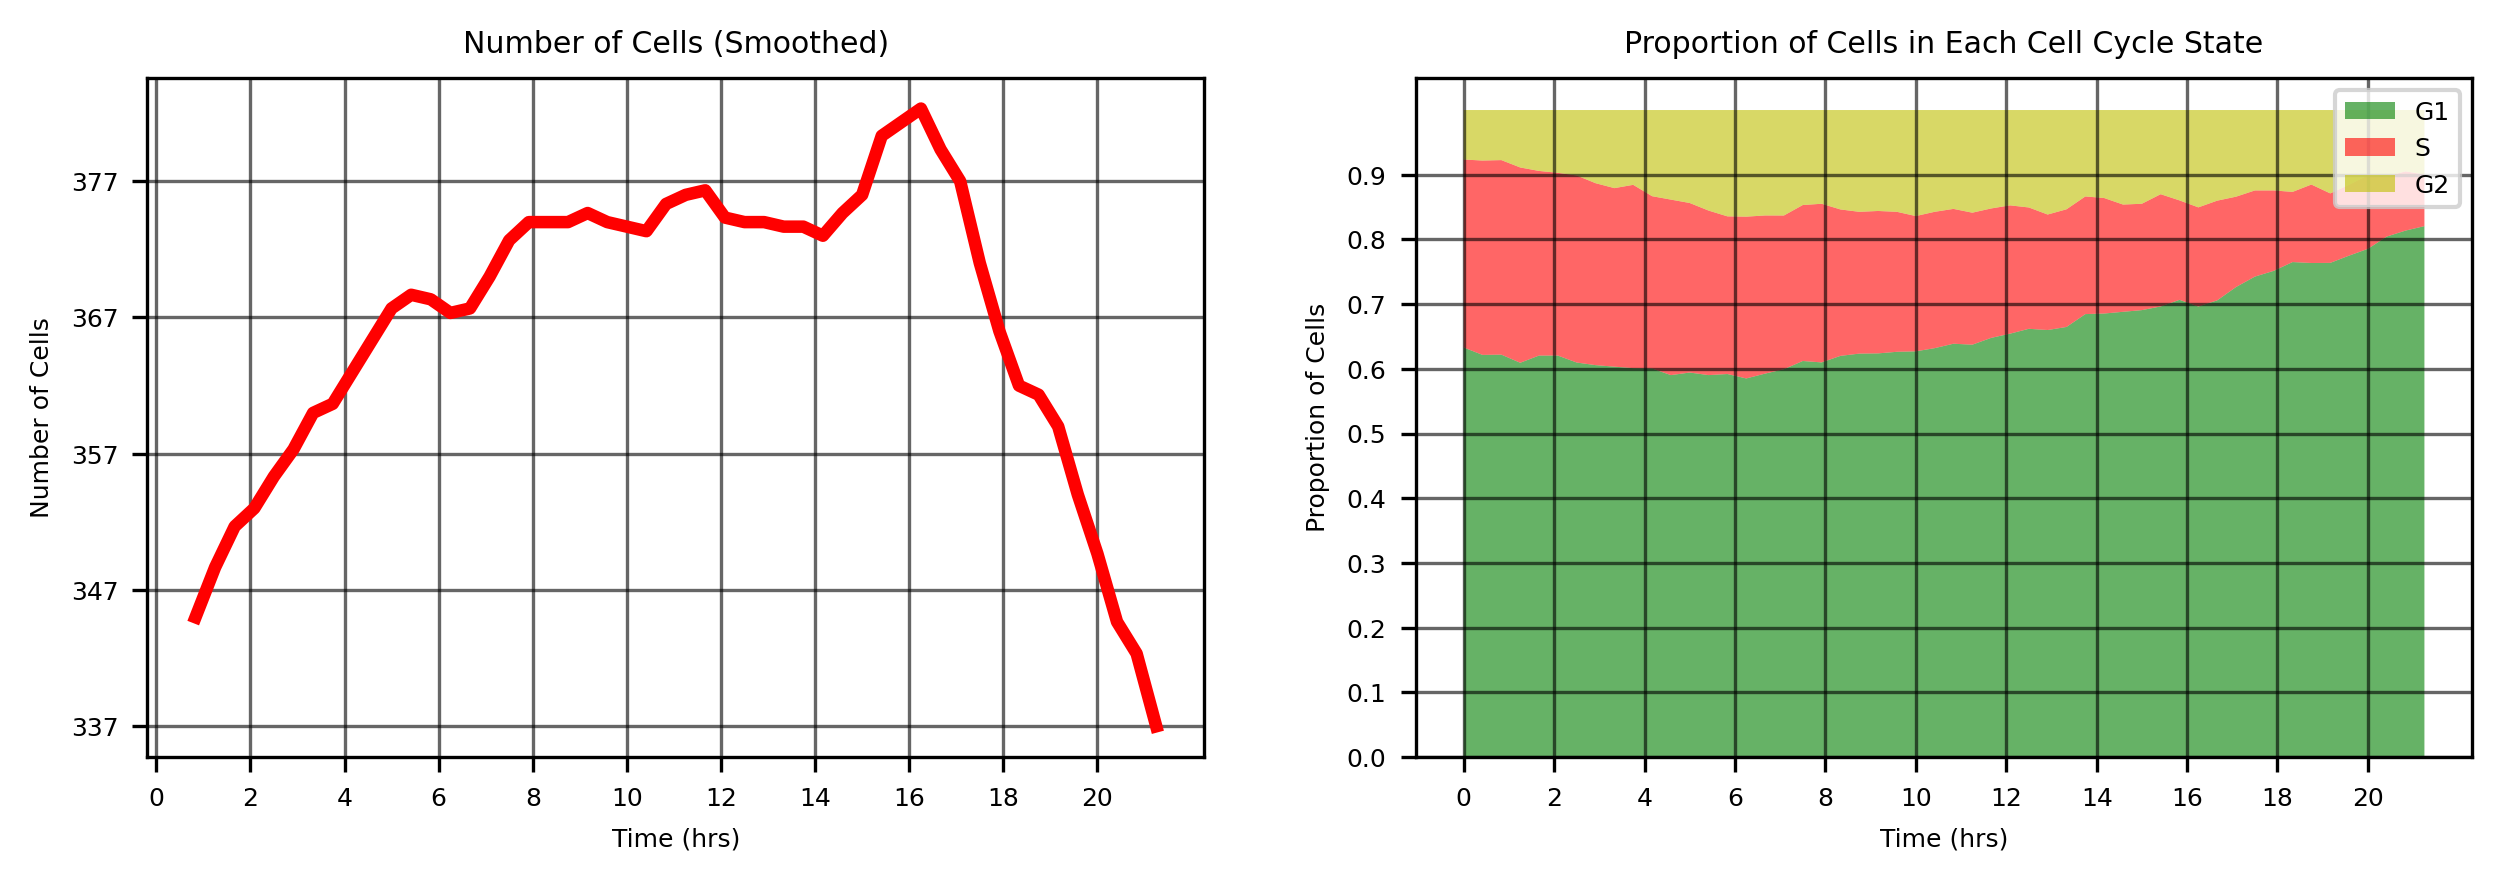

In [46]:

plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 300
fig, (ax1, ax2) = plt.subplots(1, 2)


grped['MA'] = grped['total_all'].rolling(window=3).mean()

ax1.plot(grped['Time'], grped['MA'], c='r', ls='-', lw=3)
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Number of Cells")
ax1.set_title(f"Number of Cells (Smoothed)")

ax1.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax1.set_yticks(np.arange(grped['MA'].min(), grped['MA'].max(), 10))
ax1.grid(color='k', alpha=0.6)

stack = [grped['pG1'], grped['pS'], grped['pG2']]
ax2.stackplot(grped['Time'], stack, 
              labels=['G1','S','G2'], 
              colors=['g', 'r', 'y'],
              alpha=0.6)

ax2.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax2.set_yticks(np.arange(0, 1., 0.1))
ax2.grid(color='k', alpha=0.6)
ax2.legend(loc='upper right')
ax2.set_title(f"Proportion of Cells in Each Cell Cycle State")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Proportion of Cells")


Text(0, 0.5, 'Percent of Cells')

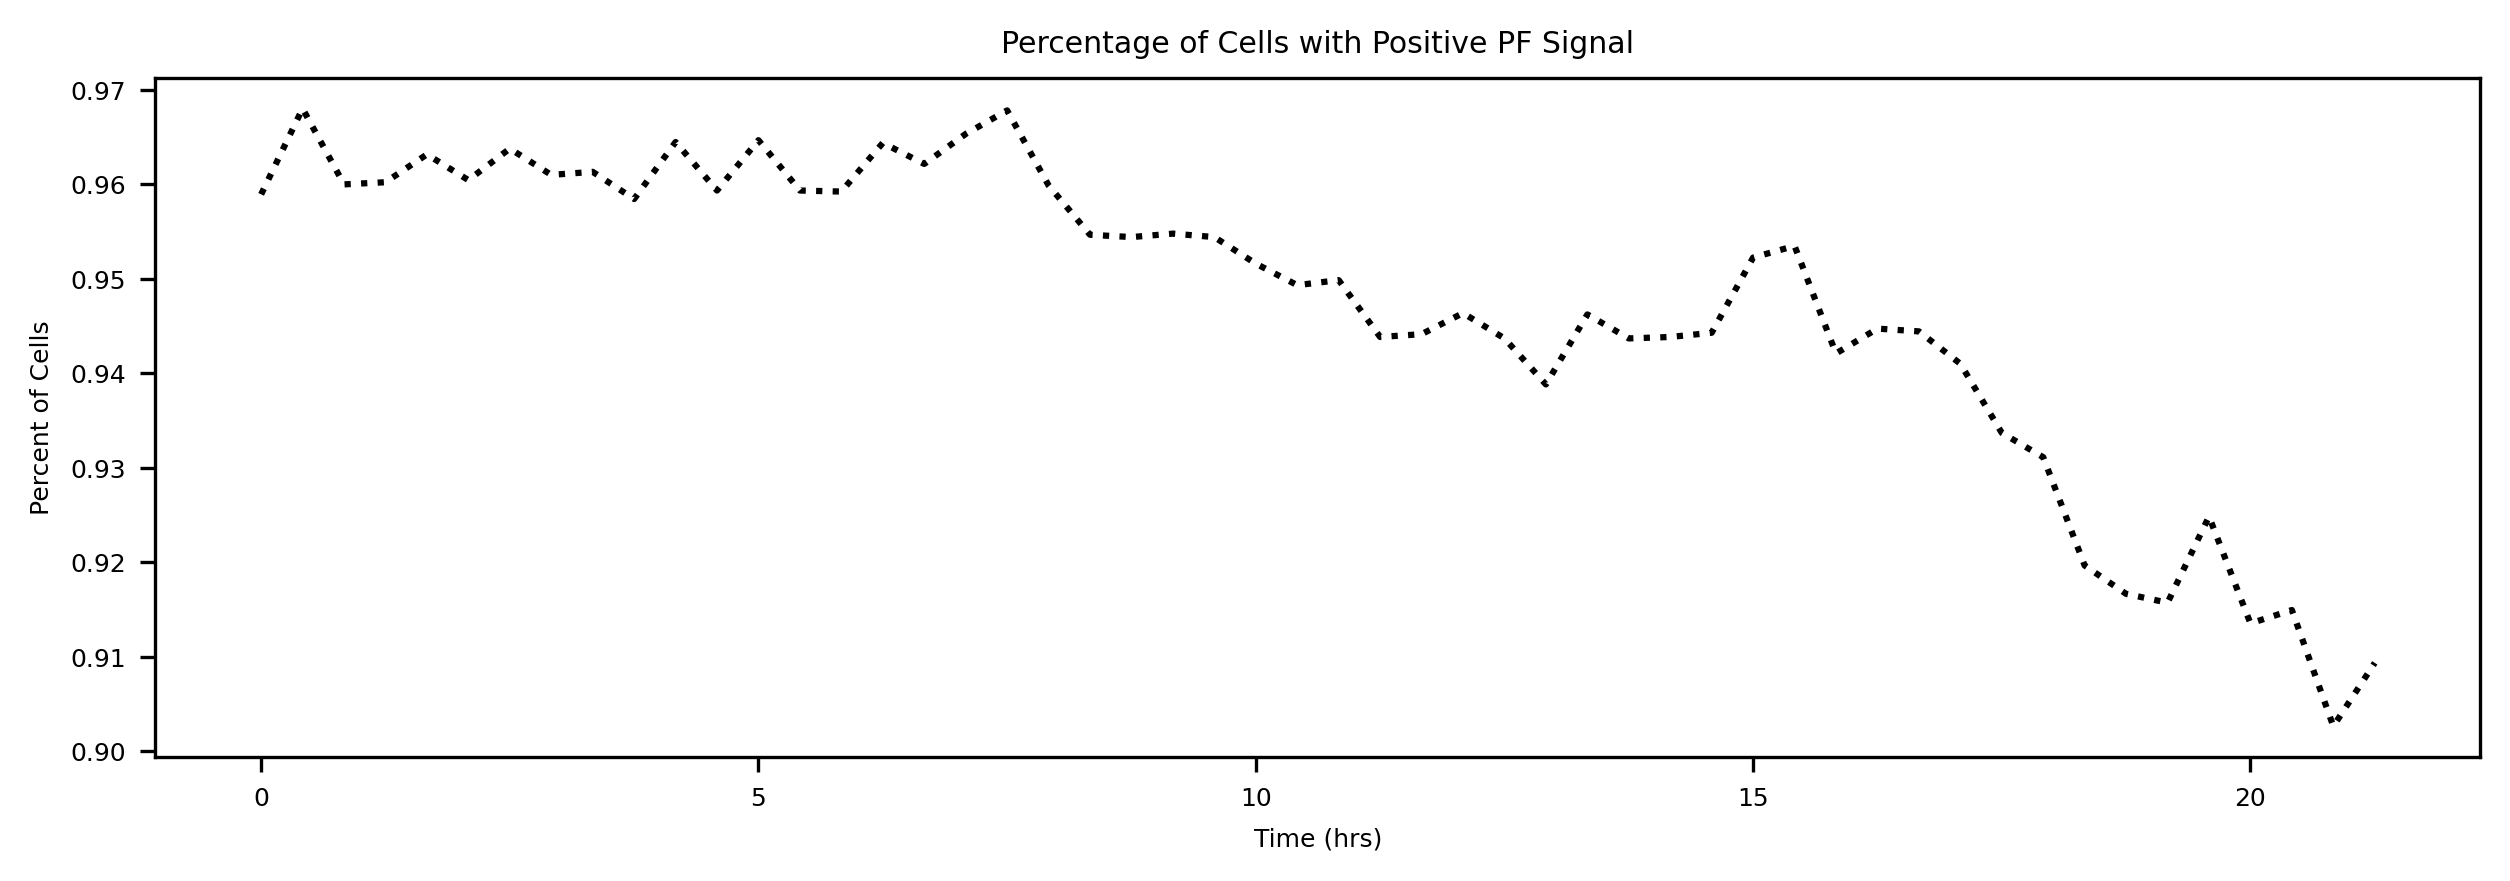

In [47]:
grped['pPF'] = grped['total'] / grped['total_all']

plt.plot(grped['Time'], grped['pPF'], c='k', ls=':')

plt.title(f"Percentage of Cells with Positive PF Signal")
plt.xlabel("Time (hrs)")
plt.ylabel("Percent of Cells")

rand_tid='control_1_184'
tmp.shape=(51, 60)


Text(136.58333333333331, 0.5, 'Estimated Cell Phase')

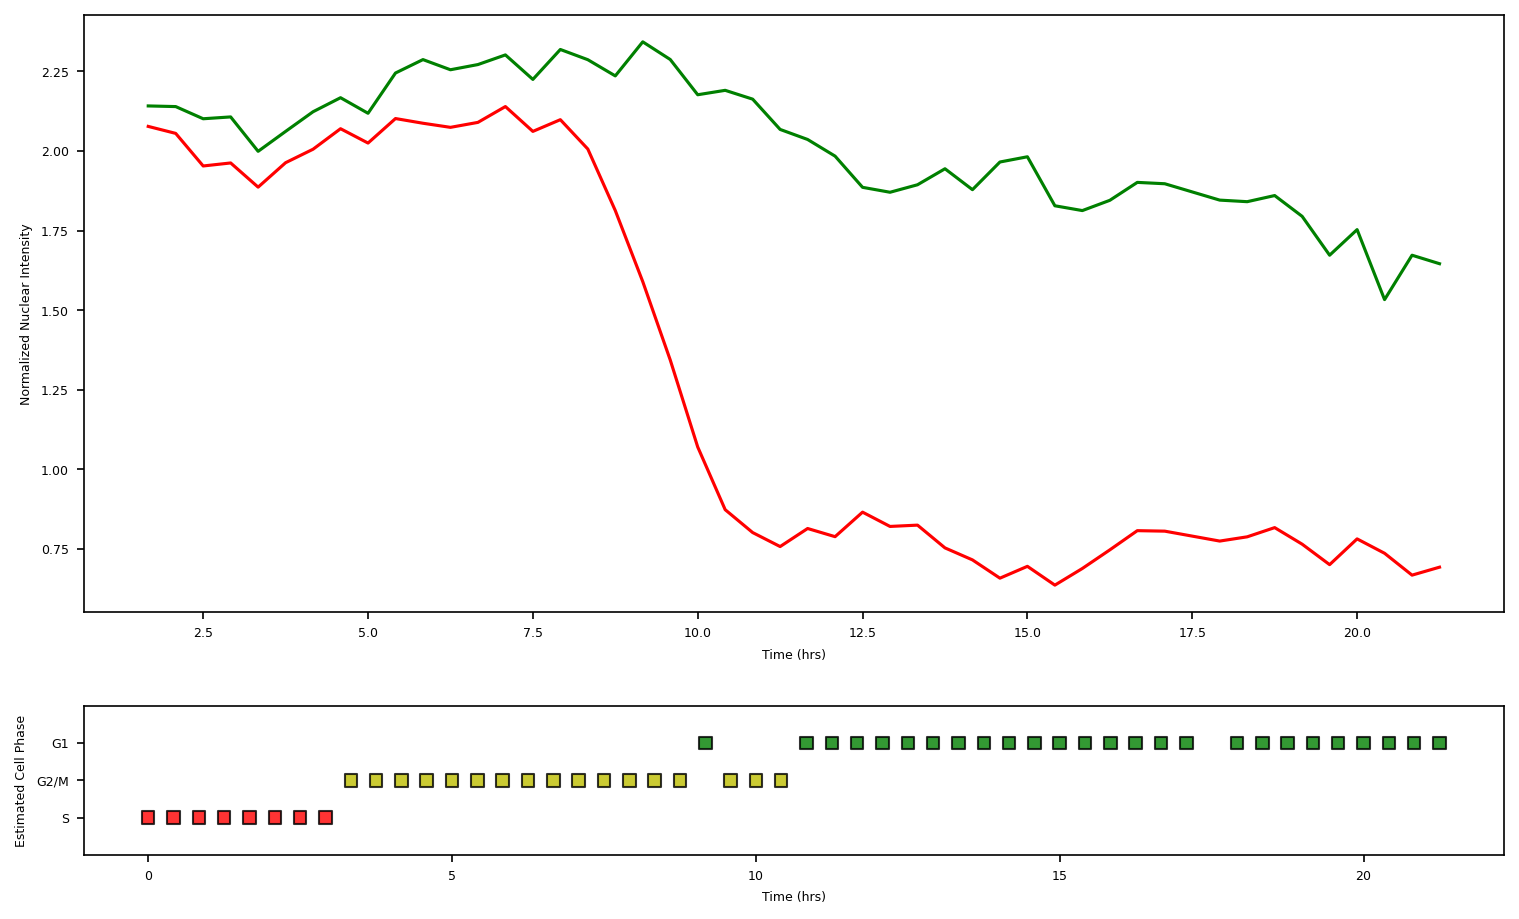

In [57]:
# visual a single track predictions

df['STEP'] = df.groupby(['TRACK_ID']).cumcount()
df['MAXSTEP'] = df.groupby(['TRACK_ID'])['FRAME'].transform("count")
df['Time'] = (df['FRAME'] * minutes_per_frame) / 60

long_tracks = df[df['MAXSTEP'] > 20.0]

rand_tid = np.random.choice(long_tracks['TRACK_ID'].unique(), 1)[0]
print(f"{rand_tid=}")

tmp = df[df['TRACK_ID'] == rand_tid]
tmp = tmp.sort_values(by='FRAME').reset_index()

print(f"{tmp.shape=}")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = 10, 6

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.25)

tmp['smooth_red'] = tmp['SNR_RED'].rolling(window=5).mean()
tmp['smooth_green'] = tmp['SNR_GREEN'].rolling(window=5).mean()

ax1.plot(tmp['Time'], tmp['smooth_red'], c='r')
ax1.plot(tmp['Time'], tmp['smooth_green'], c='g')
# ax1.set_title("PIP-FUCCI Reporter Signal Over Time")
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Normalized Nuclear Intensity")

colors = {
    'G1':'g', 
    'S':'r', 
    'G2/M':'y', 
    'NA' : 'k'
 }

ax2.scatter(tmp['Time'], 
            tmp['estimate'], 
            c = tmp['estimate'].map(colors), 
            marker="s",
            edgecolor='k',
            alpha=0.8)
n_states =  tmp['estimate'].nunique()
ax2.set_ylim(-1, n_states)
# ax2.set_title("Estimated Cell Phase")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Estimated Cell Phase")

In [58]:
df.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'FILE', 'STEP', 'MAX_STEP', 'G1', 'S', 'G2/M', 'NA', 'estimate', 'id',
       'filename', 'category_id', 'MAXS

In [59]:
outpath = f"{ROOT_DIR}processed_tracks.csv" 
df.to_csv(outpath, index=False)
print(f"{outpath=}")

outpath='/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/WH18/test/processed_tracks.csv'
